# 03 — Strategy Backtest

This notebook:
- Builds the trading signal
- Applies volatility-aware entry
- Uses volatility-targeted position sizing
- Computes performance metrics


In [12]:
import sys
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
import numpy as np
import matplotlib.pyplot as plt

from src.data_loader import load_data
from src.stats import kalman_filter, estimate_half_life
from src.strategy import build_strategy_kf
from src.backtester import run_backtest, performance_metrics


In [13]:
#df = load_data("../data/bharti_airtel_futures_2021_2024.csv",filter_expiry=[1,2,3])
df = load_data("../data/bharti_airtel_futures_raw.csv",filter_expiry=[1,2,3])

df["log_price"] = np.log(df["CLOSE"])
df = df.drop(columns=["INSTRUMENT", "SYMBOL", "STRIKE_PR","OPTION_TYP","SETTLE_PR","Unnamed: 15", "DATE1"])

df.head(10)

,Expiry Date,Open Price,High Price,Low Price,Close Price,CONTRACTS,VAL_INLAKH,Open Interest,Change in OI,Date,CLOSE,number_of_days_to_expiry,expiry_rank,log_price
0,2016-01-28,339.85,344.15,337.80,340.75,1717,7033.24,17748000,37200,2016-01-01,340.75,27,1,5.831149
1,2016-02-25,339.20,343.60,339.20,341.55,24,98.53,30000,4800,2016-01-01,341.55,55,2,5.833494
2,2016-03-31,0.00,0.00,0.00,346.80,0,0.00,0,0,2016-01-01,346.80,90,3,5.848748
3,2016-01-28,339.00,339.00,322.50,328.15,4256,16851.80,18037200,289200,2016-01-04,328.15,24,1,5.793471
4,2016-02-25,336.30,336.50,324.60,330.35,86,342.02,72000,42000,2016-01-04,330.35,52,2,5.800153
5,2016-03-31,0.00,0.00,0.00,346.80,0,0.00,0,0,2016-01-04,346.80,87,3,5.848748
6,2016-01-28,328.80,329.70,322.20,325.00,2310,9004.52,18210000,172800,2016-01-05,325.00,23,1,5.783825
7,2016-02-25,330.00,330.00,323.65,326.55,21,82.25,86400,14400,2016-01-05,326.55,51,2,5.788583
8,2016-03-31,0.00,0.00,0.00,346.80,0,0.00,0,0,2016-01-05,346.80,86,3,5.848748
9,2016-01-28,325.70,332.85,320.80,322.85,3762,14807.48,18699600,489600,2016-01-06,322.85,22,1,5.777188


In [14]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.kalman_filter import KalmanFilter

df["log_return"] = np.log(df["CLOSE"] / df["CLOSE"].shift(1))
window = 20  # ~1 trading month
df["rolling_vol"] = df["log_return"].rolling(window).std()


df["vol_rank"] = (
    df["rolling_vol"]
    .rolling(window)
    .apply(lambda x: pd.Series(x).rank(pct=True).iloc[-1])
)

df["log_price_rank"] = (
    df["log_price"]
    .rolling(window)
    .apply(lambda x: pd.Series(x).rank(pct=True).iloc[-1])
)
df["alpha"] = df["log_price"] 
#*(1- df["vol_rank"])


y = df["alpha"].to_numpy()
kalman_mean=kalman_filter(y,state_cov=0.0001,obs_cov=0.01)
df["kalman_mean"] = kalman_mean
df["kalman_spread"] = df["log_price"] - df["kalman_mean"]



In [15]:
half_life = estimate_half_life(df["kalman_spread"])
print(half_life)


2.406696667106718


C:\Users\HP\quant_strategy\src\stats.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


Building Strategy

In [18]:
df = build_strategy_kf(df, half_life,1.6,.1)


In [19]:
df = run_backtest(df, transaction_cost=0.0002) 
metrics = performance_metrics(df)
metrics


{'Annual Return': np.float64(0.1508841525536708),
 'Annual Vol': np.float64(0.13652716407837576),
 'Sharpe Ratio': np.float64(1.1051584757671606),
 'Calmar Ratio': np.float64(0.927433312506296),
 'Max Drawdown': -0.16269002905009033,
 'Win Rate': 0.5693693693693693,
 'Total Trades': 1665,
 'Winning Trades': 948,
 'Losing Trades': 717}

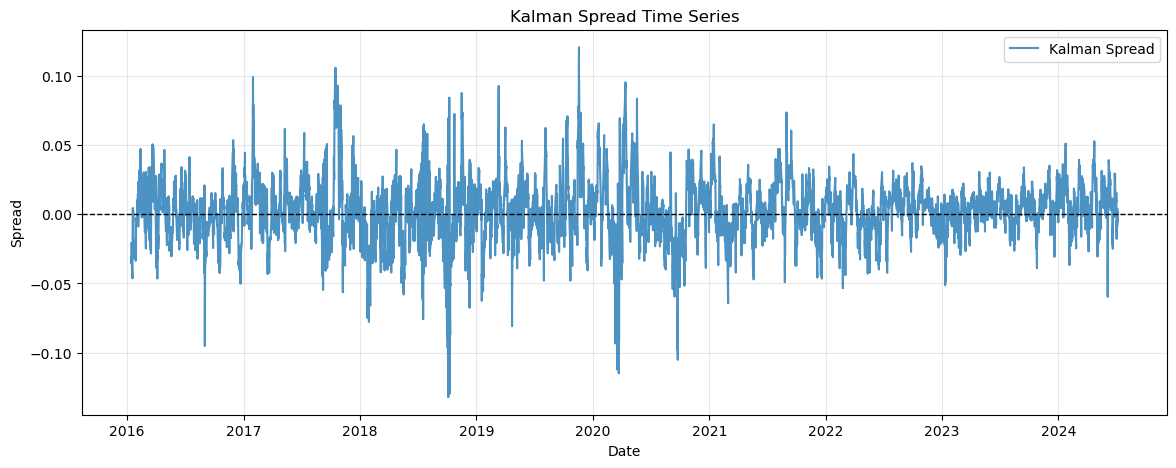

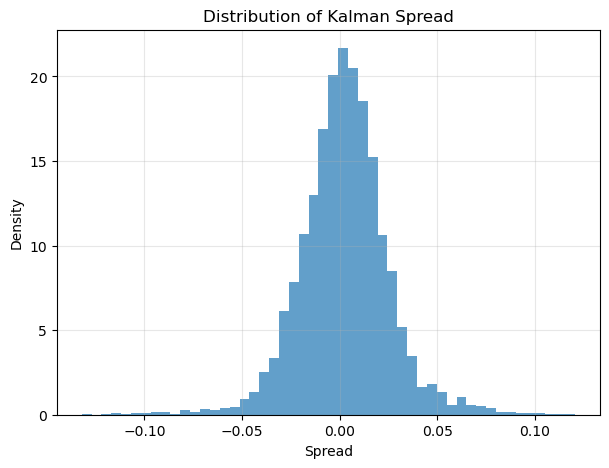

<Figure size 1000x400 with 0 Axes>

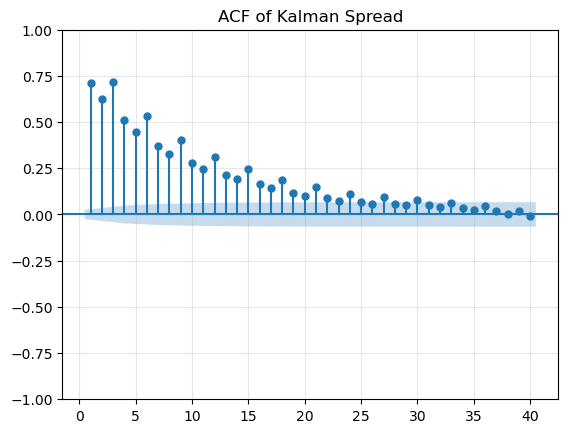

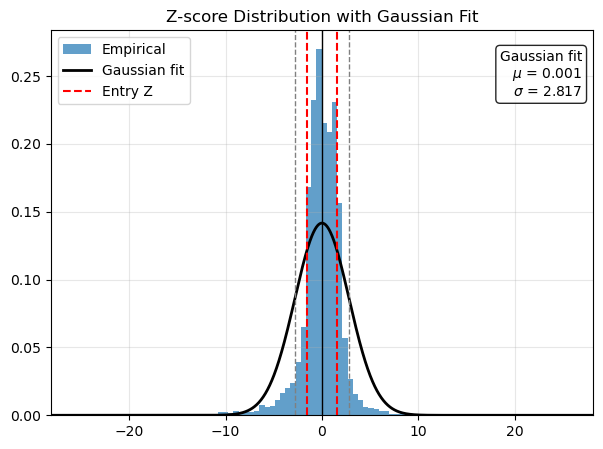

Gaussian Z-score diagnostics
----------------------------
Mean (μ)   : 0.0014
Std (σ)    : 2.8171
Entry Z    : ±1.6
Effective Entry (σ-scaled): ±4.51


In [20]:
from src.visualization import (
    plot_kalman_diagnostics,
    plot_equity_and_drawdown,
    plot_trade_and_performance_diagnostics
)
plot_kalman_diagnostics(df)


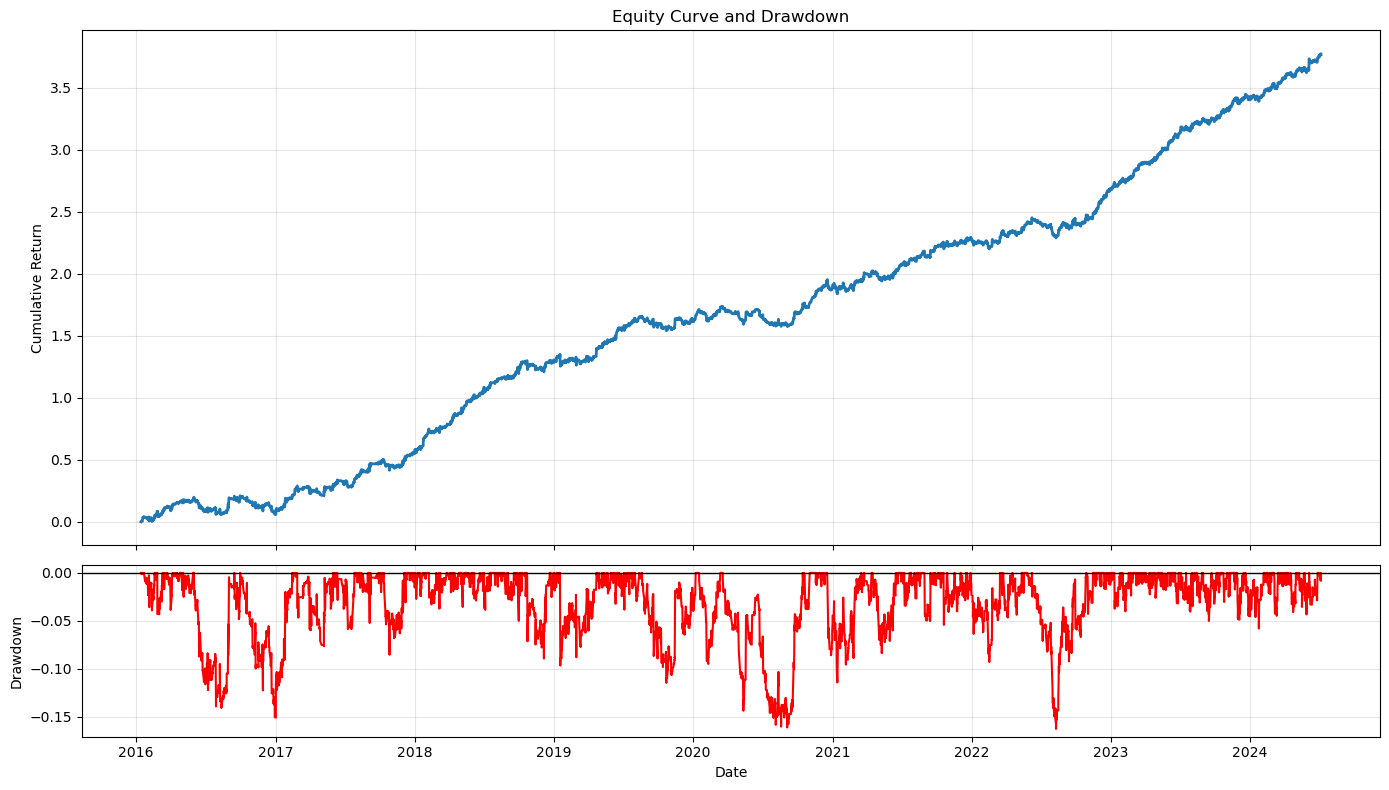

In [21]:
df["cum_return"] = df["strategy_return"].cumsum()
plot_equity_and_drawdown(df,date_col="Date",cumret_col="cum_return")
#df.head()

C:\Users\HP\quant_strategy\src\visualization.py:243: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")


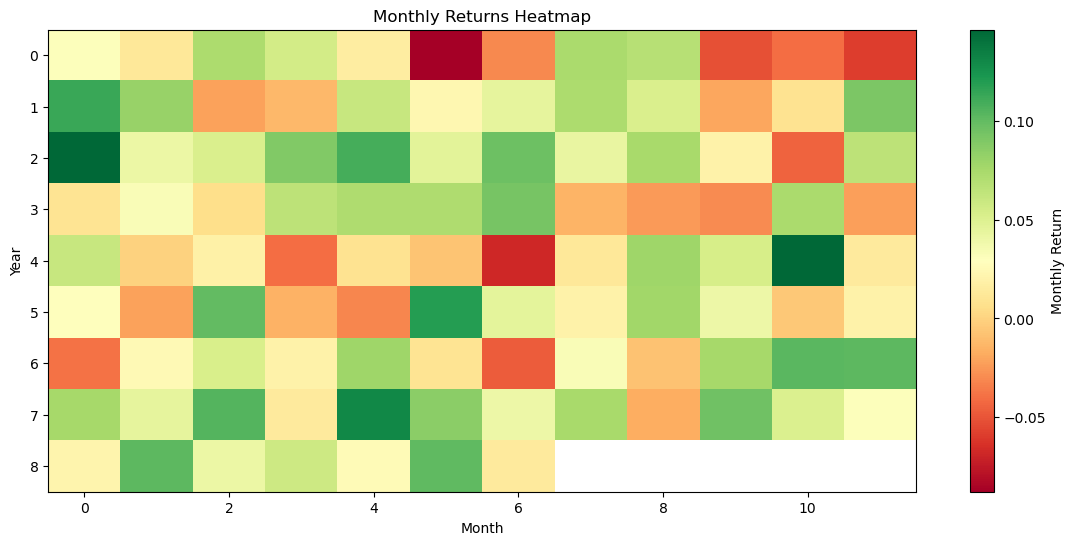

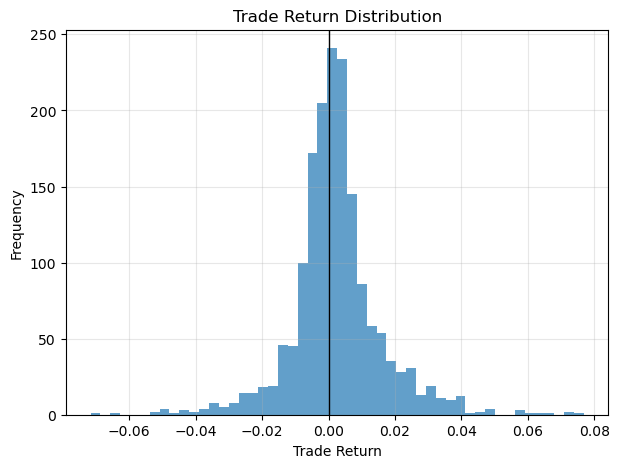

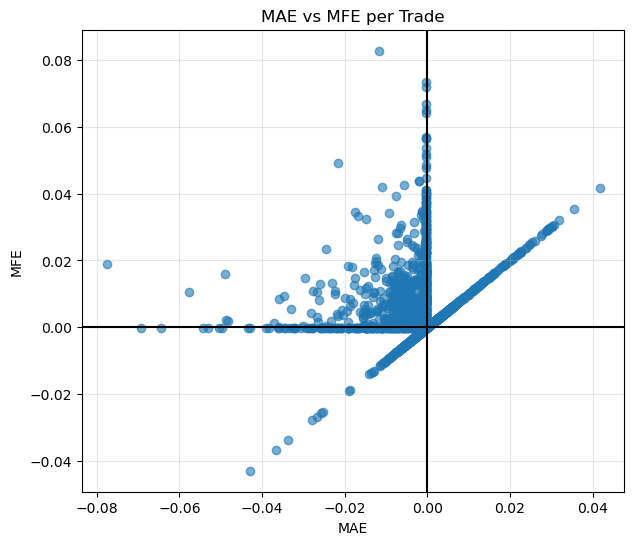

Trade diagnostics
-----------------
Trades: 1665
Mean MAE: -0.0030
Mean MFE: 0.0079


In [22]:
plot_trade_and_performance_diagnostics(
    df,
    date_col="Date",
    ret_col="strategy_return",
    trade_id_col="trade_id")